# TP Discrimination bayésienne

La "discrimination" consiste, compte tenu de "features" (variables explicatives), à prédire l'appartenance à une classe.  
La discrimination bayésienne, en s'appuyant sur une modélisation probabiliste et la règle de Bayes, permet de déterminer quelle est la probabilité d'appartenance à une classe. Après seuillage, on peut affecter un "exemple" à une classe. 

On peut évaluer les performances grace à la "matrice de confusion", qui compare (ci-dessous dans le cas binaire) les prédictions aux valeurs réelles. Le score (ou *accuracy*) est le nombre total d'exmples bien classifiés sur le nombre total d'exemples. 


### Matrice de confusion
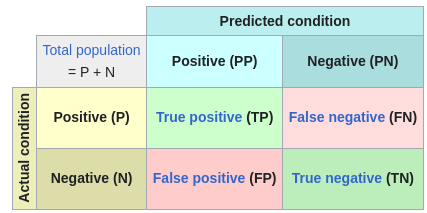

Source : [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix)

La fonction maison suivante vous permettra de visualiser la matrice de confusion (cas binaire - deux classes)

### Fonctions maison

In [136]:
# %load mycfm.py
from IPython.display import HTML, display, display_html 
import numpy as np
import pandas as pd

def mycfm(y_true, y_pred):  
    """
    Rend une jolie matrice de confusion (cas binaire) et les principaux scores associés
    
    Arguments :
    -----------
    y_true: array
         les vraies classes
    y_pred: array
         les classes prédites 
    """
    CC=pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
    try:
        display_html(CC)
    except:
        print(CC)
       
    C=np.array(CC)
    score=(C[0,0]+C[1,1])/(C[0,0]+C[1,1]+C[0,1]+C[1,0])
    precision=(C[1,1])/(C[1,1]+C[0 ,1])
    recall=(C[1,1])/(C[1,1]+C[1,0])
    print()
    print('{s:{c}<{n}}{num:2.3}'.format(s='Score',n=15,c='', num=score))
    print('{s:{c}<{n}}{num:2.3}'.format(s='Precision',n=15,c='', num=precision))
    print('{s:{c}<{n}}{num:2.3}'.format(s='Recall',n=15,c='', num=recall))


Vous pourrez éventuellement aussi utiliser la table issue de sklearn (utilisable avec plus de deux classes)
```
from sklearn.metrics import confusion_matrix
```

In [137]:
# L'histogramme standard ne permet pas de normalisation à une valeur quelconque
# ce qui est nécessaire si on veut intégrer des proportions. D'où cette version rapide. 

def myhist(x, bins=50, normed=None, color="blue", **kwargs):
    # bins peut être un vecteur des positions (gauches) des intervalles
    if isinstance(bins, int): bins = np.linspace(x.min(), x.max(), bins)
    width = bins[2] - bins[1]
    c, b = np.histogram(x, bins=bins)

    f = normed / (width * np.size(x)) if isinstance(normed,
                                                    (int, float)) else 1
    plt.bar(b[:-1], f * c, width=width, color=color, **kwargs)


#### Test
#bins=np.linspace(-6,6,50)
#myhist(X[0:N1], bins, normed=None)

### Imports utiles

In [138]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt

## Taille et poids

### Préparation

Les données peuvent être obtenues [ici](https://raw.githubusercontent.com/johnmyleswhite/ML_for_Hackers/master/02-Exploration/data/01_heights_weights_genders.csv). Vous disposez également du fichier `01_heights_weights_genders.csv` dans le répertoire courant. 

- Lire le fichier dans une variable heights_and_weights
- Afficher les premières lignes

In [139]:
heights_and_weights = pd.read_csv("01_heights_weights_genders.csv")

Le tableau initial se présente comme suit :

In [140]:
heights_and_weights.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


Le tableau initial est trié (Hommes/Femmes). On va le mélanger. 

In [141]:
np.random.seed(22)
I = np.random.choice(np.arange(10000), 10000, replace=False)

heights_and_weights = heights_and_weights.loc[I]

On commence par appliquer un certain nombre de transformations pour :
 - convertir le genre en une variable binaire (une variable numérique est nécessaire pour le module `statmodels` que l'on va employer dans la suite -- ce n'est pas nécessaire pour `sklearn`),
 - les données sont anglo-saxonnes, en tailles en pouces et poids en livres. On convertit en unités métriques,  ce sera plus agréable.
 
Pour ce faire, on utilise les méthodes `map` et  `apply`. Vous n'avez pas besoin de retenir ça. 

In [142]:
heights_and_weights['Male'] = heights_and_weights['Gender'].map({
    'Male': 1,
    'Female': 0
})
heights_and_weights['H (cm)'] = heights_and_weights['Height'].apply(
    lambda x: x * 2.54)
heights_and_weights['W (kg)'] = heights_and_weights['Weight'].apply(
    lambda x: x / 2.205)

In [143]:
heights_and_weights.head()

,Gender,Height,Weight,Male,H (cm),W (kg)
2077,Male,69.010642,177.586828,1,175.287030,80.538244
9207,Female,65.725572,130.568403,0,166.942953,59.214695
6755,Female,61.835671,118.361357,0,157.062604,53.678620
6704,Female,63.593709,144.419187,0,161.528021,65.496230
9528,Female,66.442292,145.653809,0,168.763421,66.056149


Tracer les histogrammes de la taille et du poids. 

Exemple po

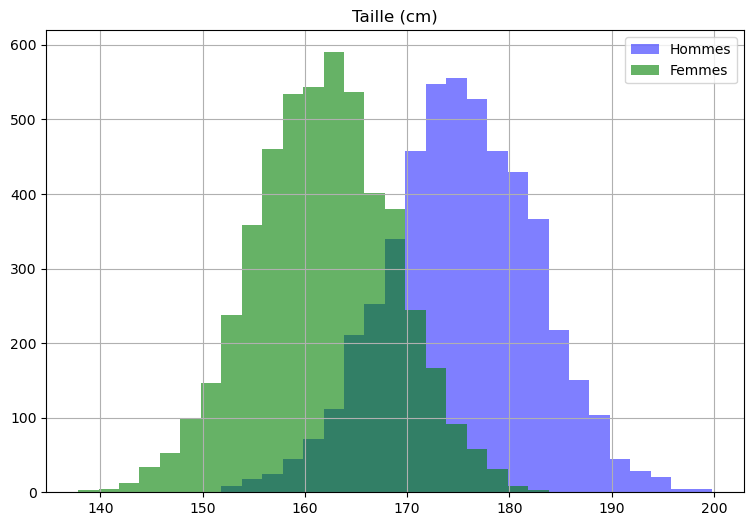

In [144]:
# 2cm bins
h = heights_and_weights['H (cm)']
male = heights_and_weights['Gender'] == 'Male'
bins1 = np.arange(h.min(), h.max(), 2.)
plt.figure(figsize=[9, 6])
h[male].hist(bins=bins1, fc='blue', label="Hommes", alpha=0.5)
h[~male].hist(bins=bins1, fc='green', label="Femmes", alpha=0.6)
plt.set_xlabel = "Taille (cm)"
plt.title("Taille (cm)")
_ = plt.legend()

- Faites la même chose pour le poids, avec un pas de 2kg

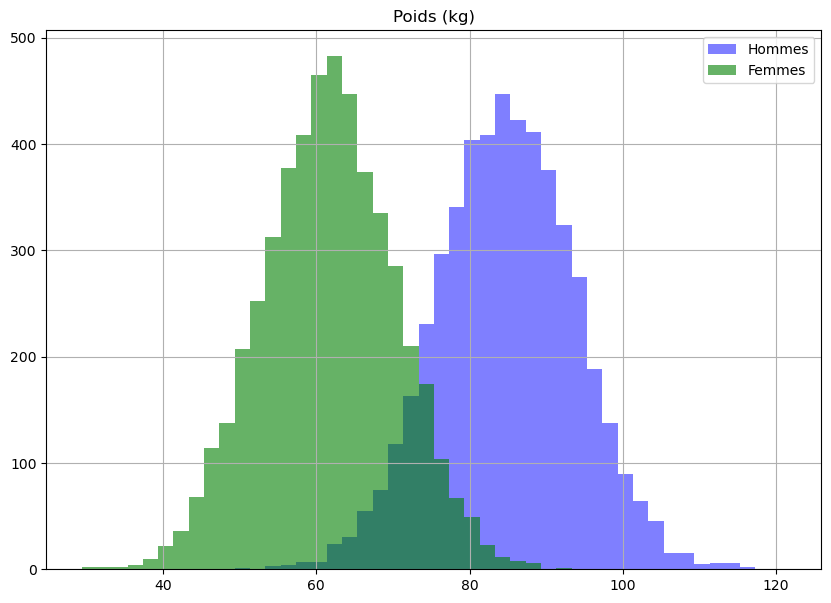

In [145]:
# 2kg bins
w = heights_and_weights['W (kg)']
male = heights_and_weights['Gender'] == 'Male'
bins1 = np.arange(w.min(), w.max(), 2.)
plt.figure(figsize=[10, 7])
w[male].hist(bins=bins1, fc='blue', label="Hommes", alpha=0.5) #steelblue'
w[~male].hist(bins=bins1, fc='green', label="Femmes", alpha=0.6) # pink
plt.set_xlabel = "Poids (kg)"
plt.title("Poids (kg)")
plt.legend();

- Comment déterminer une valeur seuil qui permettrait de classifier en homme-femme à partir de la seule donnée de la taille ? A quoi vont correspondre les erreurs ? A quelle proportion s'attendre ?  

Toujours pour la taille, définir une matrice X de "features" et une réponse (*target*) y,   la variable à prédire. 

X **doit** être une matrice (un objet 2D). Vous pouvez passer par un array en utilisant l'attribut .values. 

In [146]:
X = heights_and_weights[['H (cm)']].values
#X = heights_and_weights[['W (kg)']].values[I]
y = heights_and_weights['Male'].values

### Cas à une seule variable explicative

#### Apprentissage

Lire la documentation sur sklearn
https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda
ainsi que la documenation de la fonction disponible ici :
- https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis

- instancier le classifier, sous le nom `clf` par exemple,  
- apprendre à partir des données (méthode .fit(.,.))


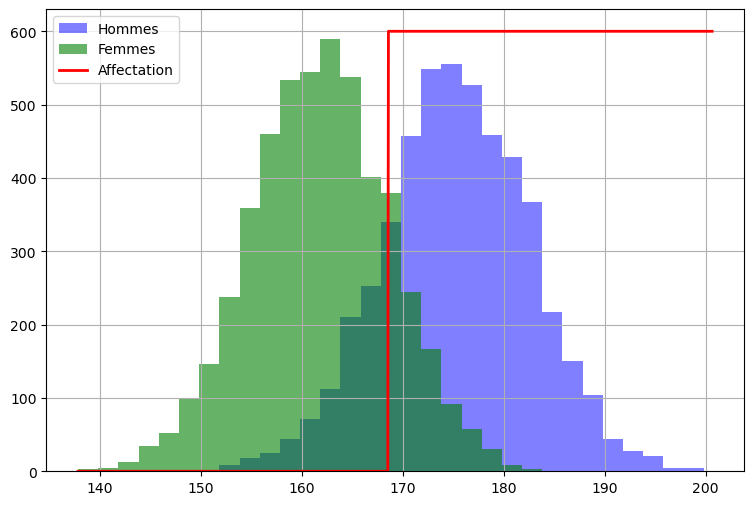

In [147]:
# instanciation du classifieur
clf = LDA()
# On apprend les choses (fit) sur la base totale -- pas de test ici
clf.fit(X, y)

# On trace  la frontière "à la main" en calculant les prédictions 
# pour tous les x
x = np.linspace(h.min(), h.max(), 1000)
xp = clf.predict(np.reshape(x, (len(x), 1)))

#**Tracé des résultats *** 
#
bins1 = np.arange(h.min(), h.max(), 2.)
plt.figure(figsize=[9, 6])
h[male].hist(bins=bins1, fc='blue', label="Hommes", alpha=0.5)
h[~male].hist(bins=bins1, fc='green', label="Femmes", alpha=0.6)

plt.plot(x, 600 * xp, linewidth=2, color="red", label="Affectation")
_ = plt.legend()


- Calculer les prédictions données par ce classifieur sur sa base d'apprentissage X
- Donner la matrice de confusion correspondante

In [148]:
preds = clf.predict(X)
mycfm(y, preds)

Predicted,0,1,All
True,,,
0,4189,811,5000
1,861,4139,5000
All,5050,4950,10000



Score          0.833
Precision      0.836
Recall         0.828


#### Généralisation

- Définir une base d'apprentissage (Xtrain, ytrain) et une base de test (Xtest, ytest) en prenant par exemple la moitié des données pour le train, et l'autre moitié pour le test. 
- Apprendre un nouveau classifieur sur train, et calculer la matrice de confusion sur test. 
- Pensez-vous que le classifieur généralise bien sur de nouvelles donnée s(non vues lors de l'apprentissage ?)

In [149]:
X = heights_and_weights[['W (kg)']].values[I]

In [150]:
M = 5000
Xtrain = X[:M, :].reshape(-1,1)
Xtest = X[M:,:].reshape(-1,1)
ytrain = y[:M]
ytest = y[M:]

clf2 = LDA()
# On apprend les choses (fit) sur la base totale -- pas de test ici
clf2.fit(Xtrain, ytrain)
preds = clf2.predict(Xtest)
mycfm(ytest, preds)

Predicted,0,1,All
True,,,
0,971,1552,2523
1,980,1497,2477
All,1951,3049,5000



Score          0.494
Precision      0.491
Recall         0.604


#### Fonction discriminante

Le modèle, lorqu'on compare les probabilités de deux classes, débouche sur une fonction "discriminante" de décision linéaire (une droite donc). f page 18 du poly, ou 
https://perso.esiee.fr/~bercherj/EL3029/DiscriminationBayesienne.html#Principe-de-la-m%C3%A9thode

Les coefficients sont donnés par les attributs `.coef()`et `.intercept()`du classifieur. 
La frontière de discrimination sera donnée par $w^T x + x_0 = 0$. 

- En déduire la valeur de seuil qui semble être utilisée pour effectuer la discrimination. 

In [151]:
clf2.coef_

array([[0.00315915]])

In [152]:
clf2.intercept_

array([-0.21296572])

In [153]:
# La frontière de décision est données par coef*x + intercept = 0
# Soit

seuil = - clf.intercept_/clf.coef_
seuil


array([[168.57360178]])

#### Probabilités d'appartenance à une classe

- Utiliser la méthode `predict_proba`du classifieur pour prédire les probas (de quoi ?) pour une taille de 164 cm. Vous passerez une matrice `[[164]]`

In [154]:
clf.predict_proba([[164],[165]] )

array([[0.77521123, 0.22478877],
       [0.72458024, 0.27541976]])

- Pour des tailles allant de 120 à 200 cm, tracer la probabilité que la personne soit un Homme. 

In [155]:
Xtest = np.arange(120, 200).reshape(-1,1)

In [156]:
probs = clf.predict_proba(Xtest)

Text(0.5, 0, 'Taille')

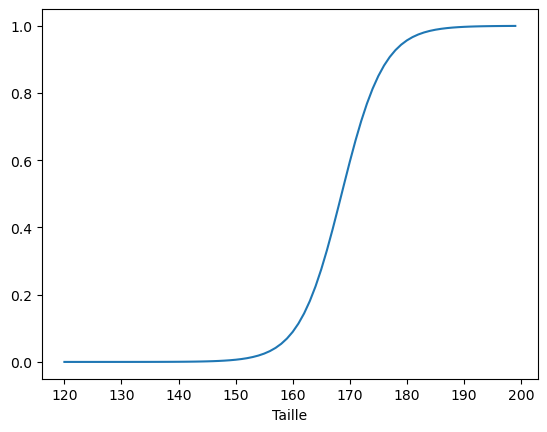

In [157]:
plt.plot(Xtest, probs[:,1])
plt.xlabel("Taille")

- Reprendre rapidement la problème de classification, mais cette fois-ci avec les données de poids (Il faut sélectionner la colonne 'W (kg)')

- Calculer la matrice de confusion, quelle est la valeur du score obtenue ?
```
X = heights_and_weights[['W (kg)']].values[I]
```

### Traitement à deux dimensions

In [158]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

Il est très simple d'intégrer plus de variables explicatives. Faisons le ici en intégrant à la fois la taille et le poids :

- créer une matrice X des tailles et poids, la réponse y correspondante
- comme précédemmment, donnez vous une base de train et test de manière à pouvoir mesurer les capacités en généralisation
- apprendre une LDA, calculer les performances

In [159]:
classifier = LDA()
X = heights_and_weights[['H (cm)', 'W (kg)']].values
y = heights_and_weights['Male'].values
# 
M = 5000
Xtrain = X[:M, :]
Xtest = X[M:,:]
ytrain = y[:M]
ytest = y[M:]

#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

# Apprentissage sur la base d'apprentissage
classifier.fit(Xtrain, ytrain)
score = classifier.score(Xtest, ytest)
print("Score sur la base de test : ", score)

Score sur la base de test :  0.922


Le score, qui était déjà très bon, a augmenté. Il est utile de raffiner le modèle !

#### Fonction discriminante

La fonction de séparation est cette fois-ci 
$$
\beta_0 + \beta_1*\text{taille} + \beta_2*\text{poids}
$$
On peut donc tracer la droite $\text{poids}=-\beta_0/\beta_2 - \beta_1/\beta_2*\text{taille}$ dans le plan (taille, poids) et comparer aux données répertoriées

- A l'aide des coefficients et de l'intercept, tracer sur le même graphe 
    - les nuages de points (avec des couleurs différentes selon hommes et femmes (par exemple deux plots)
    - la droite représentant la frontère de décision

In [160]:
print("L'intercept identifié", classifier.intercept_)
intercept = classifier.intercept_
print("Les coefficients : ", classifier.coef_[0])
coeffs = classifier.coef_[0]

L'intercept identifié [-1.20479853]
Les coefficients :  [-0.17568097  0.42088793]


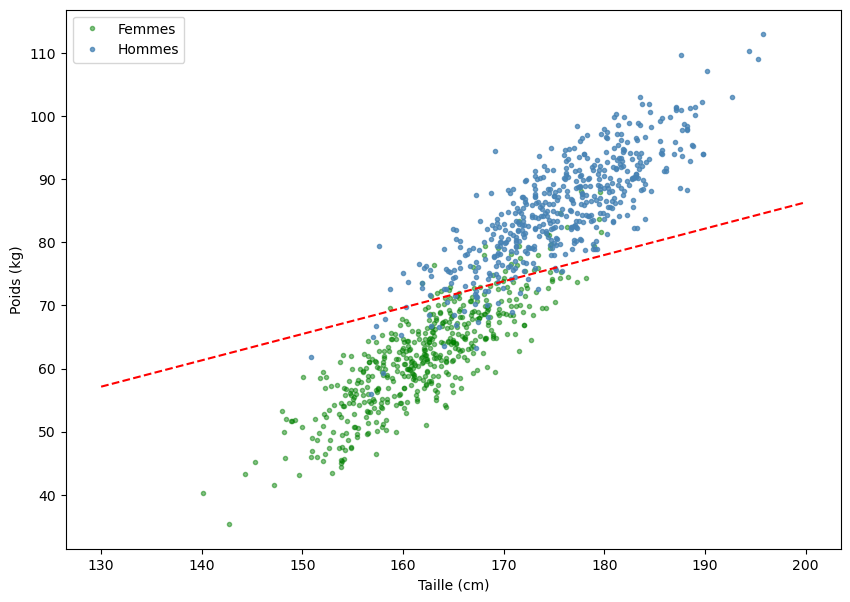

In [161]:
d0 = -intercept / coeffs[1]
d1 = -coeffs[0] / coeffs[1]

import matplotlib.pyplot as plt
#fig = plt.figure(figsize = (8, 6))
# Women points (green)
plt.figure(figsize=[10, 7])
plt.plot(
    h[~male][:500],
    w[~male][:500],
    '.',
    label='Femmes',
    color='green', #'fuchsia',#'pink',
    alpha=0.48)
# Men points (blue)
plt.plot(
    h[male][:500],
    w[male][:500],
    '.',
    label='Hommes',
    color='steelblue',
    alpha=.76)
# The separating line
plot_sepline = True
if plot_sepline:
    plt.plot(np.array([130, 200]), d0 + d1 * np.array([130, 200]), '--', color="red")
    plt.xlabel('Taille (cm)')
    plt.ylabel('Poids (kg)')
    _ = plt.legend(loc='upper left')

Comme précédemment, il est possible de prédire une classe avec la probabilité correspondante :
- Calculer quelles sont les probabilités associées à un individu de taille, poids = 170, 69.6

(utiliser `classifier.predict` et `classifier.predict_proba`)

In [162]:
taille, poids = 170, 69.6
test = np.array([taille, poids]).reshape(1, -1)
c = classifier.predict(test)
p = classifier.predict_proba(test)
f = lambda x, p: ("Femme", float(p[0][0])) if x == 0 else ("Homme", float(p[0][1]))
print("La classe prédicte est {}, avec une proba {:1.4}".format(
    f(c, p)[0], f(c, p)[1]))

La classe prédicte est Femme, avec une proba 0.8553


## Classification de digits

On considère maintenant un problème de discrimination de l'écriture manuscrite (chiffres).
Pour cela, on utilisera un modèle de Bayes naïf, avec a priori gaussien.

Le code suivant permet de lire les données et d'afficher des exemples

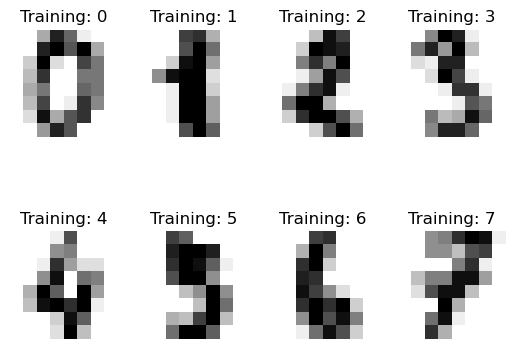

In [163]:
# Author: Gael Varoquaux <gael dot varoquaux at normalesup dot org>
# minor modifs: jfb
# License: Simplified BSD

# Standard scientific Python imports
import pylab as pl

# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits,
# let's have a look at the first 3 images, stored in the `images`
# attribute of the dataset. If we were working from image files, we
# could load them using pylab.imread. For these images know which
# digit they represent: it is given in the 'target' of the dataset.
for index, (image, label) in enumerate(zip(digits.images, digits.target)):
    if index>7: break
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=pl.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)


Chacune des images est 8x8. Si on les redimensionne en vecteurs, quelle est la taille du vecteur correspondant ? Est-il raisonnable de définir et utiliser une matrice de corrélation non diagonale dans le modèle ? (et ce sont de très petites images...). 

- Créer une matrice `data` contenant ces vecteurs. 
- A partir de cette matrice, créer une base `(X_train, y_train)` pour l'apprentissage à partir de la moitié des données, et une base de test `(X_test, y_test)` à partir de l'autre moitié

In [164]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
labels = digits.target
X_train = data[:n_samples // 2]
y_train = labels[:n_samples // 2]
X_test = data[n_samples // 2:]
y_test = labels[n_samples // 2:]


- Instancier un classificateur bayes gaussien naïf `GaussianNB`. Nommer `classifier` ce classifieur. 
- Apprendre le modèle sur (X_train, y_train)` 
- Effectuer les prédictions sur le test
- Calculer la matrice de confusion sur ces prédictions, par rapport aux véritables valeurs `y_test`. Que pensez-vous de ces résultats ?

In [165]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

In [166]:
# Create a classifier: a naive Gauss classifier
classifier = GaussianNB()

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
expected = y_test
predicted = classifier.predict(X_test)

print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Confusion matrix:
[[84  0  0  0  0  2  0  0  1  1]
 [ 0 67  2  0  0  0  0  2 13  7]
 [ 0  8 72  0  0  1  2  0  3  0]
 [ 0  2  2 72  0  2  0  2  9  2]
 [ 1  0  0  0 67  0  0 22  1  1]
 [ 0  2  0  4  0 74  1  3  2  5]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  2  0  0 12  0 72  2  1]
 [ 0  2  5  0  0  9  0  4 67  1]
 [ 1  1  0  6  0  5  1  6 11 61]]


Exécuter le code suivant (éventuellement plusieurs fois) pour visualiser des prédictions sur des éléments pris au hasard

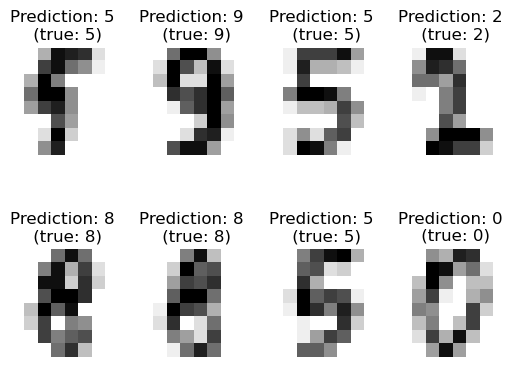

In [167]:
#take 8 examples at random (jfb)
I = np.random.choice(int(n_samples // 2), size=8, replace=False)
data_test = X_test[I] # we are indeed in the test sample (these data have not been used to learn)
data_test_target = y_test[I]

for index, (image, label) in enumerate(zip(data_test, data_test_target)):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape(8, 8), cmap=pl.cm.gray_r, 
               interpolation='nearest')
    plt.title('Prediction: {0} \n (true: {1})'.format(
        int(classifier.predict(image.reshape(1, -1))), label))

## Affairs data (Optionnel)

Ce notebook est inspiré des exemples [1](https://github.com/jseabold/pydc) et [2](http://nbviewer.ipython.org/github/justmarkham/gadsdc1/blob/master/logistic_assignment/kevin_logistic_sklearn.ipynb). 

**Données** -- 
Les données étudiées sont le "affairs dataset" fourni avec Statsmodels. les données initiales sont disponibles [ici](http://fairmodel.econ.yale.edu/vote2012/affairs.txt) et analysées dans l'[article](http://fairmodel.econ.yale.edu/rayfair/pdf/1978a200.pdf) du Journal of Political Economy(1978). Les données ont été recueillies lors d'une étude menée en 1974, par le magazine Redbook, lors de laquelle des femmes ont été interrogées sur tout un tas de choses, dont leur participation à des extramarital affairs (adultère). 

Les données contiennent 6366 observations avec 9 variables :

- rate_marriage: woman's rating of her marriage (1 = very poor, 5 = very good)
- age: woman's age
- yrs_married: number of years married
- children: number of children
- religious: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)
- educ: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)
- occupation: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)
- occupation_husb: husband's occupation (same coding as above)
- affairs: time spent in extra-marital affairs


In [168]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
#

from sklearn.model_selection import train_test_split
from sklearn import metrics

### Préparation

In [169]:
# load dataset
dta = sm.datasets.fair.load_pandas().data

Description du tableau

In [170]:
dta.describe()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.705374
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,2.203374
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.484848
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,57.599991


On crée une variable binaire: il y a tromperie ou non.

In [171]:
# add "affair" column: 1 represents having affairs, 0 represents not
dta['affair'] = (dta.affairs > 0).astype(int)

Analyse rapide des tromperies

In [172]:
dta.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


Quand il y a tromperie, le mariage est noté plus faible (attention à la notion de causalité). 

Autre vision (à nouveau, attention à la causalité)

In [173]:
dta.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


Encoder les variables catégorielles (qualitatives/non quantitatives) et créer un nouveau dataframe. Vous pourrez utiliser `pd.get_dummies`ou un `ÒneHotEncoder`. 

In [174]:
dummy_occup = pd.get_dummies(dta['occupation'], prefix='occupation')
dummy_occup_h = pd.get_dummies(dta['occupation_husb'], prefix='occup_h')

In [175]:
dummy_occup_h.head()

,occup_h_1.0,occup_h_2.0,occup_h_3.0,occup_h_4.0,occup_h_5.0,occup_h_6.0
0,0,0,0,0,1,0
1,0,0,0,1,0,0
2,0,0,0,0,1,0
3,0,0,0,0,1,0
4,0,0,0,1,0,0


In [176]:
cols_a_garder=['rate_marriage','age','yrs_married','children','religious','educ']
dataset=dta[cols_a_garder].join(dummy_occup).join(dummy_occup_h)
y=dta['affair']

On a donc un tableau avec les colonnes suivantes. 

In [177]:
dataset.columns

Index(['rate_marriage', 'age', 'yrs_married', 'children', 'religious', 'educ',
       'occupation_1.0', 'occupation_2.0', 'occupation_3.0', 'occupation_4.0',
       'occupation_5.0', 'occupation_6.0', 'occup_h_1.0', 'occup_h_2.0',
       'occup_h_3.0', 'occup_h_4.0', 'occup_h_5.0', 'occup_h_6.0'],
      dtype='object')

### Discrimination

Ensuite c'est très facile : on instancie un modèle (par exemple LDA), on "fit", on regarde le score

In [178]:
#
model = LDA()
X_train, X_test, y_train, y_test = train_test_split(dataset,y)

res = model.fit(X_train, y_train)
#
#score - quel score obtenu ?
model.score(X_test, y_test)

0.7198492462311558

Les coefficients obtenus sont les suivants

In [179]:
res.coef_

array([[-0.7861829 , -0.05774841,  0.10778406,  0.02493363, -0.36208042,
        -0.00134813, -0.49909846, -0.30590647,  0.08033606, -0.1833631 ,
         0.44428382,  0.67754033, -0.12514934,  0.03429402,  0.10850438,
         0.00708811, -0.0533587 ,  0.00452911]])

On relie les coefficients aux variables. Interprétations ?

In [180]:
pd.DataFrame(res.coef_, columns=dataset.columns)

,rate_marriage,age,yrs_married,children,religious,educ,occupation_1.0,occupation_2.0,occupation_3.0,occupation_4.0,occupation_5.0,occupation_6.0,occup_h_1.0,occup_h_2.0,occup_h_3.0,occup_h_4.0,occup_h_5.0,occup_h_6.0
0,-0.786183,-0.057748,0.107784,0.024934,-0.36208,-0.001348,-0.499098,-0.305906,0.080336,-0.183363,0.444284,0.67754,-0.125149,0.034294,0.108504,0.007088,-0.053359,0.004529


mariage bien noté, proba dune "affaire" diminue, 
plus sentiment religieux, plus la proba d'affaire diminue
plus occupation 1 (étudiant), plus la proba diminue
plus occupation 6, plus la proba augmente

On peut prédire :

In [181]:
age= 22
children= 8
educ= 16
occup_h_1=0
occup_h_2=0
occup_h_3=0 
occup_h_4=1
occup_h_5=0 
occup_h_6=0
occupation_1= 0
occupation_2= 0
occupation_3= 1
occupation_4= 0
occupation_5=0
occupation_6= 0
rate_marriage= 4
religious = 5
yrs_married= 7

test=[rate_marriage, age, yrs_married, children, religious, educ, occupation_1, occupation_2, occupation_3, occupation_4,occupation_5,
occupation_6, occup_h_1, occup_h_2,occup_h_3, occup_h_4, occup_h_5,
occup_h_6]

In [182]:

print("proba d'avoir une 'affaire' : ", 
      res.predict_proba(np.array(test).reshape(1, -1))[0][1])

proba d'avoir une 'affaire' :  0.21166250455809943


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
